In [30]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [31]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import cobra
from molmass import Formula
from cobra.io import read_sbml_model
from experiments.fast_dFBA import setup_drawdown, MichaelisMentenBounds, dFBA
from utils.cobra_utils import get_or_create_exchange
from utils.utils import pp
from parameters.drawdown import *
from plotting.diagnostic import uptakes_and_secretions, plot_pathway, plot_metabolite_fluxes

In [32]:
MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "RPOM_provisional_biomass"
DATA_FILE = "../data/clean/CUE/cue_data.csv"

# Load data
data = pd.read_csv(DATA_FILE)

# Load and set up model
model = read_sbml_model(MODEL_FILE)
setup_drawdown(model)

# Set up Michaelis-Menten medium
ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

# Get V_maxes
V_max_glc = 10 * abs(float(ex_glc._annotation["Experimental rate"]))
V_max_ace = 10 * abs(float(ex_ace._annotation["Experimental rate"]))

dynamic_medium = {
    ex_glc: MichaelisMentenBounds("Glucose[e]", V_max_glc, K_M.to("mM").magnitude),
    ex_ace: MichaelisMentenBounds(
        "ACET[e]", V_max_ace, K_M.to("mM").magnitude)
}

# Initial state
initial_conditions = data[["Initial_mM_Glucose",
                            "Initial_mM_Acetate"]].drop_duplicates().values

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [33]:
initial_glucose, initial_acetate = initial_conditions[3, :]

initial_biomass = (data[(data["Type"] == "counts") &
                        (data["Time (h)"] == 0) &
                        (data["Initial_mM_Glucose"] == initial_glucose) &
                        (data["Initial_mM_Acetate"] == initial_acetate)
                        ]["Value"].mean() * (1/u.mL) * MASS_PER_CELL).to("g/L").magnitude
tmax = (data[(data["Type"] == "counts") & (data["Initial_mM_Glucose"] == initial_glucose) & (
    data["Initial_mM_Acetate"] == initial_acetate)]["Time (h)"].max())

substrates = {
    "Glucose[e]" : initial_glucose,
    "ACET[e]": initial_acetate
}

with model:
    for exchange, bounds in dynamic_medium.items():
        bounds.bound(exchange, substrates[bounds.substrate_id])

    # Using lexicographic optimization,
    # first optimize for biomass, then for the exchange fluxes
    # (holding optimal biomass as a constraint),
    # thus guaranteeing a unique optimal set of exchange fluxes.
    lex_constraints = cobra.util.add_lexicographic_constraints(
        model, [BIOMASS_ID, "EX_glc", ex_ace.id], ['max', "max", "max"])
    fluxes = lex_constraints.values

fluxes *= initial_biomass
fluxes

array([ 0.00069602, -0.00720359,  0.        ])

In [34]:
ECOLI_MODEL_FILE = "../model/ecoli.xml"
ecoli = read_sbml_model(ECOLI_MODEL_FILE)

In [35]:
# change compartments to match r pom convention
for metabolite in ecoli.metabolites:
    if metabolite.id[-2] == "_":
        comp = metabolite.id[-1]
        metabolite.id = metabolite.id[:-2] + f"[{comp}]"
    else:
        metabolite.id = metabolite.id.replace("CCO-PM-BAC-NEG", "[p]")

    # change underscores to dashes to match r pom convention
    metabolite.id = metabolite.id.replace("_", "-")

from collections import Counter
Counter(met.id[-3:] for met in ecoli.metabolites)

Counter({'[c]': 1227, '[p]': 1257, '[e]': 1197})

In [36]:
with ecoli:
    glc_ex = ecoli.reactions.get_by_id("GLC_p_EXCHANGE_RXN")
    glc_ex.bounds = (0, 0.4285802668951506)
    
    b = ecoli.reactions.get_by_id("BIOMASS_EQUATION")

    bad_guys = ["KDO2-LIPID-IVA[e]",
                "MET-tRNAs[c]",
                "Charged-MET-tRNAs[c]"
                ]
    bad_guys = [ecoli.metabolites.get_by_id(bastard) for bastard in bad_guys]
    
    b.add_metabolites({bastard : -b.metabolites[bastard] for bastard in bad_guys})


    # mets = b.metabolites
    # charged_met_tRNA = ecoli.metabolites.get_by_id()
    # val = mets[charged_met_tRNA]
    # b.add_metabolites({charged_met_tRNA : -val})
    # ecoli.add_boundary(charged_met_tRNA, type="sink")
    print(ecoli.optimize())

<Solution 0.063 at 0x7f7b62113fa0>


In [37]:
# Create mapping for common metabolites between rpom and e coli models

metabolites_data = pd.DataFrame([
    {"id" : met.id,
    "source" : "rpom",
    "link": None,
    "rpom_reactions" : len(met.reactions),
    "ecoli_reactions" : 0}
    for met in model.metabolites])

unmatched_metabolites = []
for metabolite in ecoli.metabolites:
    matches = (metabolites_data["id"] == metabolite.id)
    metabolites_data["link"][matches] = metabolite.id
    metabolites_data["ecoli_reactions"][matches] = len(metabolite.reactions)

    if not any(matches):
        unmatched_metabolites.append({"id": metabolite.id, "source" : "ecoli", "link" : None, "rpom_reactions" : 0, "ecoli_reactions" : len(metabolite.reactions)})

metabolites_data = pd.concat([metabolites_data, pd.DataFrame(unmatched_metabolites)])

metabolites_data["has_link"] = ~metabolites_data["link"].isnull()
metabolites_data[["source", "has_link"]].groupby(["source", "has_link"]).size()
# ecoli_met_ids = {met.id : met for met in ecoli.metabolites}
# common_met_encoding = {}
# i = 0
# for met in model.metabolites:
#     if met.id in ecoli_met_ids:
#         common_met_encoding[met.id] = i
#         i += 1

# len(rpom_to_ecoli_mets)

/tmp/ipykernel_5132/1164973836.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5132/1164973836.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



source  has_link
ecoli   False       2784
rpom    False        791
        True         897
dtype: int64

In [38]:
# metabolites_data.to_excel("metabolite_links_rpom_to_ecoli.xlsx")

In [39]:
len(ecoli.metabolites)

3681

In [40]:
import plotly.graph_objects as go

RPOM_COLOR = "rgb(0,100,255)"
ECOLI_COLOR = "rgb(0,150, 90)"
SHARED_COLOR = "rgb(0, 230, 230)"

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        label=["<i>R. pom</i> metabolites (1688)", "<i>E. coli</i> metabolites (3681)",
               "Shared (897)", "Unique to <i>R. pom</i> (791)", "Unique to <i>E. coli</i> (2784)"],
        color=[RPOM_COLOR, ECOLI_COLOR, SHARED_COLOR, RPOM_COLOR, ECOLI_COLOR]
    ),
    link=dict(
        source=[0, 0, 1, 1],
        target=[2, 3, 2, 4],
        value=[897/2, 791, 897/2, 2784]
    ))])

fig.update_layout(title_text="Shared Metabolites", font_size=12)
fig.update_layout(
    width=500,
    height=400
)
fig.show()

In [41]:
# Create a common metabolite encoding (numbering) so as to match reactions
common_met_encoding = {met: i for i, met in enumerate(metabolites_data[metabolites_data["has_link"]]["id"])}

In [57]:
def encode_reaction(reaction, metabolite_encoding):
    def freeze_encoding(encoding):
        keylist = list(encoding.keys())
        valuelist = list(encoding.values())
        
        order = np.argsort(keylist)
        return tuple(f"{keylist[i]}:{valuelist[i]}" for i in order)
    
    try:
        encoding_fwd = {metabolite_encoding[met.id] : coeff for met, coeff in reaction.metabolites.items()}
        encoding_rev = {metabolite_encoding[met.id] : -coeff for met, coeff in reaction.metabolites.items()}
        return freeze_encoding(encoding_fwd), freeze_encoding(encoding_rev)
    except KeyError:
        # One or more metabolites are not in the common encoding
        return None, None


reaction_data = pd.DataFrame([
    {"id" : reaction.id,
    "source" : "rpom",
    "stoich_fwd" : encode_reaction(reaction, common_met_encoding)[0],
    "stoich_rev" : encode_reaction(reaction, common_met_encoding)[1],
    "rpom_flux" : reaction.flux,
    "link": None,
    "ecoli_flux" : None}
    for reaction in model.reactions])

unmatched_reactions = []
for reaction in ecoli.reactions:
    enc_fwd, enc_rev = encode_reaction(reaction, common_met_encoding)
    matches = reaction_data["stoich_fwd"] == enc_fwd

    if matches.any() and reaction_data["link"][matches].values[0] is not None:
        print(f"{reaction} matches with {reaction_data['id'][matches].values[0]} which already has match {reaction_data['link'][matches].values[0]}")

    reaction_data["link"][matches] = reaction.id
    reaction_data["ecoli_flux"][matches] = reaction.flux

    if not any(matches):
        unmatched_reactions.append({
            "id" : reaction.id,
            "source": "ecoli",
            "stoich_fwd" : enc_fwd,
            "stoich_rev" : enc_rev,
            "rpom_flux" : None,
            "link" : None,
            "ecoli_flux" : reaction.flux})

reaction_data = pd.concat([reaction_data, pd.DataFrame(unmatched_reactions)])
reaction_data["has_link"] = ~reaction_data["link"].isnull()
reaction_data.groupby(["source", "has_link"]).size()

/tmp/ipykernel_5132/1036777500.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5132/1036777500.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ATPASE_RXN: ATP[c] + WATER[c] --> ADP[c] + PROTON[c] + Pi[c] matches with ATPASE-RXN which already has match ABC_42_RXN_CPD_15629/ATP/WATER//CPD_15629/ADP/Pi/PROTON__46_46__
TRANS_RXN_145: WATER[p] <=> WATER[c] matches with H2Otpp which already has match TRANS_RXN0_547[CCO_PM_BAC_NEG]_WATER//WATER.29.
TRANS_RXN_283: ATP[c] + BETAINE[p] + WATER[c] --> ADP[c] + BETAINE[c] + PROTON[c] + Pi[c] matches with TRANS-RXN-283 which already has match RXN_8638_BETAINE/ATP/WATER//BETAINE/ADP/Pi/PROTON.41.
TRANS_RXN_324: ATP[c] + CPD-821[p] + WATER[c] --> ADP[c] + CPD-821[c] + PROTON[c] + Pi[c] matches with RXN-8638-CPD-821/ATP/WATER//CPD-821/ADP/Pi/PROTON.41. which already has match RXN_8638_CPD_821/ATP/WATER//CPD_821/ADP/Pi/PROTON.41.


source  has_link
ecoli   False       3481
rpom    False       1380
        True         595
dtype: int64

In [43]:
reaction_data["has_encoding"] = ~reaction_data["stoich_fwd"].isnull()
reaction_data.groupby(["source", "has_encoding"]).size()

source  has_encoding
ecoli   False           3027
        True             454
rpom    False            902
        True            1073
dtype: int64

In [45]:
# Note to self: there must be 3 (?) reactions with multiple matches - need to look into this :(

In [87]:
COMMON_COLOR_RPOM = "rgb(0, 150, 250)"
COMMON_COLOR_ECOLI = "rgb(0, 200, 150)"
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        label=["<i>R. pom</i> reactions (1975)",  # 0
                "<i>E. coli</i> reactions (4079)",  # 1
                "Only common metabolites (1073)",  # 2, rpom
                "Some unique metabolites (902)",  # 3, rpom
                "Only common metabolites (1049)",  # 4, ecoli
                "Some unique metabolites (3027)",  # 5, ecoli
                "Shared (595)",  # 6
                "Unique to <i>R. pom</i> (1380)",  # 7
                "Unique to <i>E. coli</i> (3481)"  # 8
                ],
        color=[RPOM_COLOR, ECOLI_COLOR, COMMON_COLOR_RPOM, RPOM_COLOR, COMMON_COLOR_ECOLI, ECOLI_COLOR, SHARED_COLOR, RPOM_COLOR, ECOLI_COLOR]
    ),
    link=dict(
        source=[0, 0, 1, 1, 2, 2, 3, 4, 4, 5],
        target=[2, 3, 4, 5, 7, 6, 7, 6, 8, 8],
        value=[1073, 902, 1049, 3027, 478, 595/2, 902, 595/2, 454, 3027]
    ))])

fig.update_layout(title_text="Shared Reactions", font_size=12)
fig.update_layout(
    width=700,
    height=500
)
fig.show()

In [70]:
3481 - 3027

454

In [48]:
reaction_data.shape[0]

5456

In [49]:
(reaction_data["source"] == "ecoli").sum() + 595

4076

In [50]:
reaction_data[(reaction_data["source"] == "ecoli") & reaction_data["has_encoding"]].shape[0] + 595

1049

Text(0, 0.5, '|Flux (E. coli)|')

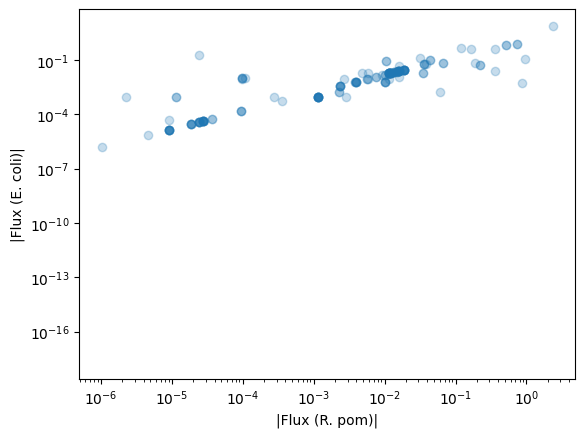

In [51]:
fig, ax = plt.subplots()
subset_data = reaction_data[reaction_data["has_link"]]
ax.scatter(subset_data["rpom_flux"].abs(), subset_data["ecoli_flux"].abs(), alpha=0.25)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("|Flux (R. pom)|")
ax.set_ylabel("|Flux (E. coli)|")

In [96]:
import plotly.express as px

subset_data = reaction_data[reaction_data["has_link"]]

# Add small positive value to prevent log(0)
subset_data["rpom_flux_adj"] = 1e-18 + subset_data["rpom_flux"].abs()
subset_data["ecoli_flux_adj"] = 1e-18 + subset_data["ecoli_flux"].abs()

subset_data["reaction_str"] = [model.reactions.get_by_id(rxn).reaction for rxn in subset_data["id"]]
fig = px.scatter(subset_data,
                 x="rpom_flux_adj",
                 y="ecoli_flux_adj",
                 custom_data=["id", "reaction_str", "rpom_flux", "ecoli_flux"],
                 labels={
                    "rpom_flux_adj" : "|Flux (<i>R. pom</i>)|",
                    "ecoli_flux_adj" : "|Flux (<i>E. coli</i>)|"
                 },
                 log_x = True,
                 log_y = True,
                 opacity=0.5)
fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[0]}</b>",
        "rpom flux: %{customdata[2]}",
        "ecoli flux: %{customdata[3]}",
        "rxn: %{customdata[1]}"
    ]))

# fig.update_yaxes(range=[abs(subset_data["ecoli_flux"][subset_data["ecoli_flux"] != 0].min()), subset_data["ecoli_flux"].max()])

fig.update_layout(
    width=800,
    height=600,
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
    xaxis = dict(
        showexponent = 'all',
        exponentformat = 'power'
    ),
)
fig.show()
fig.write_html("img/scatter_interactive.html")

/tmp/ipykernel_5132/3234676781.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5132/3234676781.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5132/3234676781.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
subset_data

,id,source,stoich_fwd,stoich_rev,rpom_flux,link,ecoli_flux,has_link,has_encoding,reaction_str
4,1.1.1.8-RXN,rpom,"(1:-1.0, 2:1.0, 3:-1.0, 8:-1.0, 9:1.0)","(1:1.0, 2:-1.0, 3:1.0, 8:1.0, 9:-1.0)",5.757139e-03,GLYC3PDEHYDROGBIOSYN_RXN_GLYCEROL_3P/NAD//DIHY...,0.008802,True,True,DIHYDROXY-ACETONE-PHOSPHATE[c] + NADH[c] + PRO...
30,1.8.4.8-RXN,rpom,"(3:2.0, 38:1.0, 39:1.0, 40:-1.0, 41:-1.0, 42:1.0)","(3:-2.0, 38:-1.0, 39:-1.0, 40:1.0, 41:1.0, 42:...",1.018953e-02,1.8.4.8_RXN,0.0,True,True,PAPS[c] + Red-Thioredoxin[c] --> 3-5-ADP[c] + ...
35,2-DEHYDROPANTOATE-REDUCT-RXN,rpom,"(3:-1.0, 25:-1.0, 26:1.0, 50:-1.0, 51:1.0)","(3:1.0, 25:1.0, 26:-1.0, 50:1.0, 51:-1.0)",2.385212e-05,2_DEHYDROPANTOATE_REDUCT_RXN,0.000036,True,True,2-DEHYDROPANTOATE[c] + NADPH[c] + PROTON[c] --...
36,2-ISOPROPYLMALATESYN-RXN,rpom,"(3:1.0, 16:-1.0, 17:1.0, 20:-1.0, 52:1.0, 53:-...","(3:-1.0, 16:1.0, 17:-1.0, 20:1.0, 52:-1.0, 53:...",1.865645e-02,2_ISOPROPYLMALATESYN_RXN,0.028515,True,True,2-KETO-ISOVALERATE[c] + ACETYL-COA[c] + WATER[...
38,2-METHYLCITRATE-DEHYDRATASE-RXN,rpom,"(20:1.0, 54:1.0, 55:-1.0)","(20:-1.0, 54:-1.0, 55:1.0)",1.000000e-18,2_METHYLCITRATE_DEHYDRATASE_RXN,0.0,True,True,CPD-622[c] --> CPD-1136[c] + WATER[c]
...,...,...,...,...,...,...,...,...,...,...
1917,XANPRIBOSYLTRAN-RXN,rpom,"(67:1.0, 181:-1.0, 415:1.0, 420:-1.0)","(67:-1.0, 181:1.0, 415:-1.0, 420:1.0)",1.000000e-18,XANPRIBOSYLTRAN_RXN,0.0,True,True,PRPP[c] + XANTHINE[c] --> PPI[c] + XANTHOSINE-...
1918,XANTHOSINEPHOSPHORY-RXN,rpom,"(30:-1.0, 180:1.0, 420:1.0, 697:-1.0)","(30:1.0, 180:-1.0, 420:-1.0, 697:1.0)",1.000000e-18,XANTHOSINEPHOSPHORY_RXN,0.0,True,True,Pi[c] + XANTHOSINE[c] --> RIBOSE-1P[c] + XANTH...
1919,XMPXAN-RXN,rpom,"(20:-1.0, 30:1.0, 415:-1.0, 697:1.0)","(20:1.0, 30:-1.0, 415:1.0, 697:-1.0)",1.000000e-18,5_NUCLEOTID_RXN[CCO_CYTOSOL]_XANTHOSINE_5_PHOS...,0.0,True,True,WATER[c] + XANTHOSINE-5-PHOSPHATE[c] --> Pi[c]...
1971,RXN0-1133,rpom,"(17:-1.0, 53:1.0, 884:-1.0, 885:1.0)","(17:1.0, 53:-1.0, 884:1.0, 885:-1.0)",1.000000e-18,RXN0_1133,0.0,True,True,CO-A[c] + Pyruvate-dehydrogenase-acetylDHlipoy...


In [54]:
def encode_reactions(reactions, metabolite_encodings):
    def freeze_encoding(encoding):
        keylist = list(encoding.keys())
        valuelist = list(encoding.values())
        
        order = np.argsort(keylist)
        return tuple(f"{keylist[i]}:{valuelist[i]}" for i in order)
    result = {}
    for reaction in reactions:
        if all(met.id in metabolite_encodings for met in reaction.metabolites):
            encoding_fwd = {metabolite_encodings[met.id] : coeff for met, coeff in reaction.metabolites.items()}
            encoding_rev = {metabolite_encodings[met.id] : -coeff for met, coeff in reaction.metabolites.items()}

            # Needs to be a bijective mapping
            result[reaction] = (freeze_encoding(encoding_fwd), freeze_encoding(encoding_rev))
            result[freeze_encoding(encoding_fwd)] = reaction
            result[freeze_encoding(encoding_rev)] = reaction
    return result

rpom_encoded_reactions = encode_reactions(model.reactions, common_met_encoding)
ecoli_encoded_reactions = encode_reactions(ecoli.reactions, common_met_encoding, reaction_as_key=False)

rpom_to_ecoli_reactions = {}
for reaction, encodings in rpom_encoded_reactions.items():
    if not isinstance(reaction, Reaction):
        continue
    
    try:
        rpom_to_ecoli_reactions[reaction] = ecoli_encoded_reactions[encodings[0]]
    except KeyError:
        continue
# for reaction, encodings in ecoli_encoded_reactions.items():
#     try:
#         rpom_reaction = rpom_encoded_reactions[]
#         rpom_to_ecoli_reactions[reaction] = ecoli_encoded_reactions[encodings[0]]
#     except KeyError:
#         continue

print(len(rpom_to_ecoli_reactions))


TypeError: encode_reactions() got an unexpected keyword argument 'reaction_as_key'

Text(0.5, 0, 'flux (R pom)')

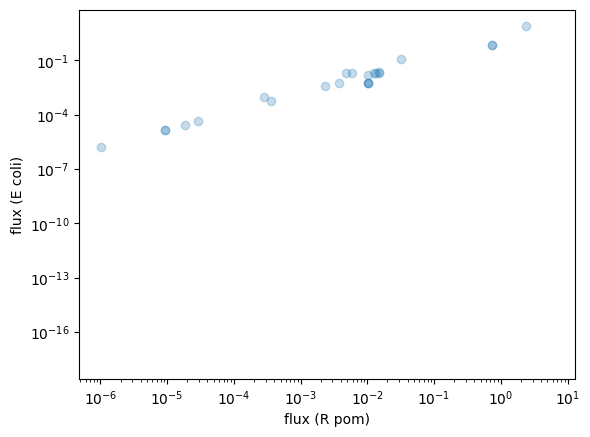

In [ ]:
fluxes_rpom = [abs(rxn.flux) for rxn in rpom_to_ecoli_reactions.keys()]
fluxes_ecoli = [abs(rxn.flux) for rxn in rpom_to_ecoli_reactions.values()]

fig, ax = plt.subplots()
ax.scatter(fluxes_rpom, fluxes_ecoli, alpha=0.25)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("flux (E coli)")
ax.set_xlabel("flux (R pom)")

In [ ]:
ecoli_mets = set(strip_compartment(met.id, ecoli=True) for met in ecoli.metabolites)
common_mets = []
for met in model.metabolites:
    if strip_compartment(met.id) in ecoli_mets:
        common_mets.append(strip_compartment(met.id))

ecoli_common_reactions = [rxn for rxn in ecoli.reactions if all(strip_compartment(met.id, ecoli=True) in common_mets for met in rxn.metabolites)]
rpom_common_reactions = [rxn for rxn in model.reactions if all(strip_compartment(met.id, ecoli=False) in common_mets for met in rxn.metabolites)]


ecoli_reaction_encodings = {}
for rxn in ecoli_common_reactions:
    reaction_encoding = {
        common_mets.index(strip_compartment(met.id, ecoli=True)) : coeff
        for met, coeff in rxn.metabolites.items()
    }
    ecoli_reaction_encodings[rxn] = reaction_encoding

rpom_reaction_encodings = {}
for rxn in rpom_common_reactions:
    reaction_encoding = {
        common_mets.index(strip_compartment(met.id, ecoli=False)) : coeff
        for met, coeff in rxn.metabolites.items()
    }
    rpom_reaction_encodings[rxn] = reaction_encoding

In [ ]:
common_reactions = {}

l_keys = list(ecoli_reaction_encodings.keys())
l_values = list(ecoli_reaction_encodings.values())

for reaction, encoding in rpom_reaction_encodings.items():
    if encoding in ecoli_reaction_encodings.values():
        common_reactions[reaction] = l_keys[l_values.index(encoding)]

Text(0.5, 0, 'flux (R pom)')

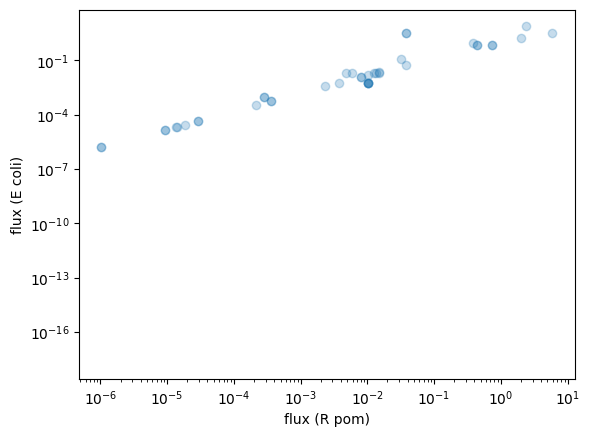

In [ ]:
fluxes_rpom = [abs(rxn.flux) for rxn in common_reactions.keys()]
fluxes_ecoli = [abs(rxn.flux) for rxn in common_reactions.values()]

fig, ax = plt.subplots()
ax.scatter(fluxes_rpom, fluxes_ecoli, alpha=0.25)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("flux (E coli)")
ax.set_xlabel("flux (R pom)")

In [ ]:
[(rxn_rpom, rxn_ecoli, rxn_rpom.flux, rxn_ecoli.flux) for rxn_rpom, rxn_ecoli in common_reactions.items() if rxn_ecoli.flux > 3.1]

[(<Reaction Htex at 0x7fc985ba03a0>,
  <Reaction PROTON_c_EXCHANGE_RXN at 0x7fc9848c52d0>,
  5.916669530089914,
  3.15),
 (<Reaction PItex at 0x7fc985a9b6d0>,
  <Reaction Pi_c_EXCHANGE_RXN at 0x7fc9848c5180>,
  0.03831374395020015,
  3.15),
 (<Reaction TRANS-RXN0-470 at 0x7fc98536f790>,
  <Reaction Pi_c_EXCHANGE_RXN at 0x7fc9848c5180>,
  0.03831374395020015,
  3.15),
 (<Reaction TRANS-RXN1G48-17-PROTON/PROTON//PROTON/PROTON.29. at 0x7fc9852920b0>,
  <Reaction PROTON_c_EXCHANGE_RXN at 0x7fc9848c52d0>,
  0.0,
  3.15)]

In [ ]:
model.reactions.get_by_id("TRANS-RXN1G48-17-PROTON/PROTON//PROTON/PROTON.29.")

Reaction identifier,TRANS-RXN1G48-17-PROTON/PROTON//PROTON/PROTON.29.
Name,TRANS-RXN1G48-17-PROTON/PROTON//PROTON/PROTON.29.
Memory address,0x7fc9852920b0
Stoichiometry,PROTON[p] --> PROTON[c] H+ --> H+
GPR,G1G48-1419
Lower bound,0.0
Upper bound,1000.0
